In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

2025-05-21 10:44:21.286906: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 10:44:21.725238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 10:44:21.893283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 10:44:21.939143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 10:44:22.241162: I tensorflow/core/platform/cpu_feature_guar

# CNN전이학습_data_augmentation
* 전이학습: 사전에 훈련된 모델을 가져와서 사용하는 것
* data_agmentation: 이미지 데이터의 경우 데이터가 적어서 확보가 어려움, 비쌈, 기존 이미지데이터에 변형을 가해서 데이터 수를 늘리는 작업(회전, 확대, 축소, 자르기)

## Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [3]:
image = load_img("./data/catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

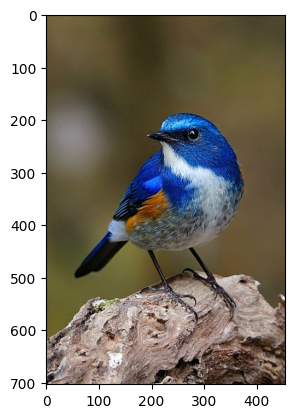

In [4]:
plt.imshow(image)
plt.show()

# Image Augmentation(이미지증폭)

In [5]:
imggen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest")

In [6]:
image_array.shape

(703, 454, 3)

2.차원늘리기

In [7]:
image_array.reshape((1, )+ image_array.shape).shape

(1, 703, 454, 3)

In [8]:
image_array = image_array.reshape((1, )+ image_array.shape)
image_array.shape

(1, 703, 454, 3)

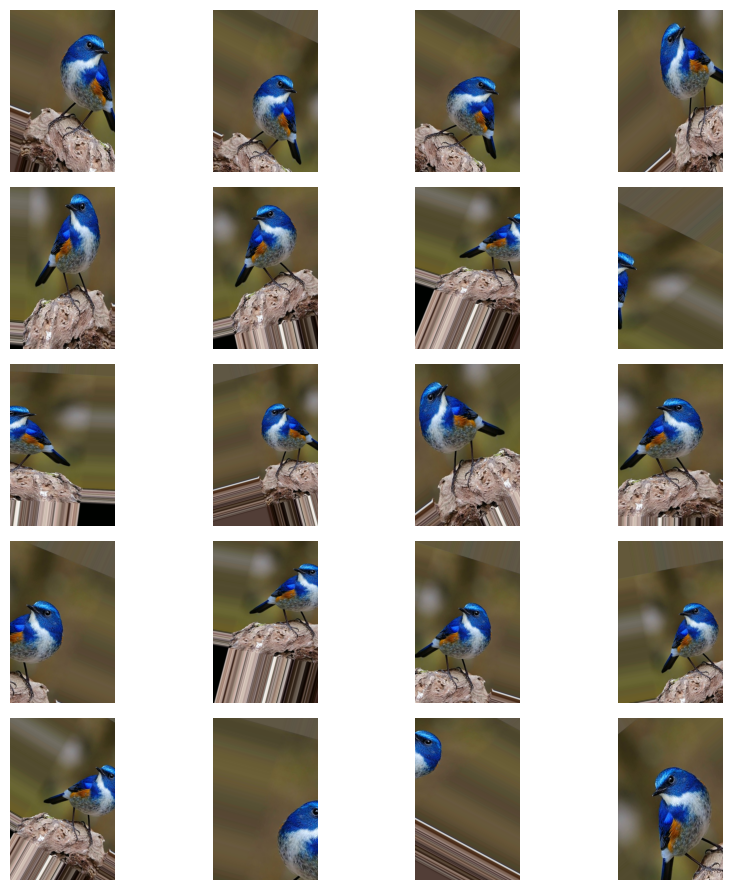

In [9]:
fig, axes = plt.subplots(5,4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(imggen.flow(image_array, batch_size=1)):
    if i >= 20:
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# image_augemtation을 이용한 개/고양이 분류모델 만들기


In [10]:
# 데이터 로드
train_dir = "./data/catanddog/train/"
valid_dir = "./data/catanddog/validation/"
batch_size = 16 # 한 번에 불러오는 사진의 개수, 분석 모델에 따라서 16(큼)~32(작음) 사이로 지정
image_size= (224,224) # 모델의 입력 크기에 맞춤

In [11]:
# 이미지 증강
train_aug = ImageDataGenerator(
    rescale=1./225,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.6,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest")

valid_aug = ImageDataGenerator(rescale=1./255)

# 이미지 제너레이터
train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size =  batch_size,
    class_mode = 'categorical',
    shuffle=True,
    seed=42)

valid_gen = valid_aug.flow_from_directory(
    valid_dir,
    target_size = image_size,
    batch_size =  batch_size,
    class_mode = 'categorical',
    shuffle=True,
    seed=42)

X_batch, y_batch = next(train_gen)
print(X_batch.shape)
print(y_batch.shape)
print(train_gen.class_indices)

Found 2222 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
(16, 224, 224, 3)
(16, 2)
{'Cat': 0, 'Dog': 1}


# CNN을 이용한 개 /고양이 분류

In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(224,224,3)))
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.25))  
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(2, activation='softmax'))
cnn_model.summary()

I0000 00:00:1747824284.935456      29 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747824285.081500      29 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747824285.081546      29 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747824285.089202      29 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747824285.089404      29 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,815,266 (10.74 MB)

 Trainable params: 2,815,266 (10.74 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import tensorflow as tf

Epoch 1/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.5229 - loss: 0.6892
Epoch 1: val_loss improved from inf to 0.66814, saving model to ./model/cnn_catanddog.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 74s 504ms/step - accuracy: 0.5230 - loss: 0.6891 - val_accuracy: 0.5714 - val_loss: 0.6681
Epoch 2/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5622 - loss: 0.6797
Epoch 2: val_loss improved from 0.66814 to 0.65865, saving model to ./model/cnn_catanddog.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 65s 464ms/step - accuracy: 0.5622 - loss: 0.6797 - val_accuracy: 0.6735 - val_loss: 0.6586
Epoch 3/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5528 - loss: 0.6838
Epoch 3: val_loss improved from 0.65865 to 0.64915, saving model to ./model/cnn_catanddog.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 64s 458ms/step - accuracy: 0.5529 - loss: 0.6838 - val_accuracy: 0.6837 - val_loss: 0.6492
Epoch 4/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.5741 - loss: 0.6

Epoch 25/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6808 - loss: 0.5982
Epoch 25: val_loss did not improve from 0.53527
139/139 ━━━━━━━━━━━━━━━━━━━━ 53s 379ms/step - accuracy: 0.6807 - loss: 0.5982 - val_accuracy: 0.7449 - val_loss: 0.5404
Epoch 26/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.6669 - loss: 0.6042
Epoch 26: val_loss did not improve from 0.53527
139/139 ━━━━━━━━━━━━━━━━━━━━ 50s 359ms/step - accuracy: 0.6669 - loss: 0.6041 - val_accuracy: 0.7143 - val_loss: 0.5493
Epoch 27/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6873 - loss: 0.5825
Epoch 27: val_loss did not improve from 0.53527
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 423ms/step - accuracy: 0.6873 - loss: 0.5825 - val_accuracy: 0.7347 - val_loss: 0.5627
Epoch 28/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6969 - loss: 0.5767
Epoch 28: val_loss did not improve from 0.53527
139/139 ━━━━━━━━━━━━━━━━━━━━ 53s 384ms/step - accuracy: 0.6969 - loss: 0.5767 - val_

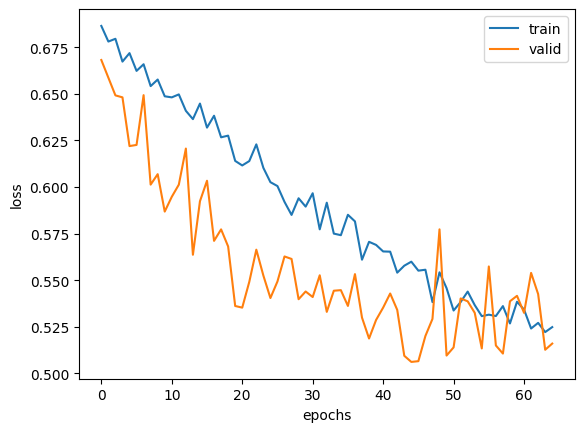

In [75]:
cnn_model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['accuracy'])
model_path = "./model/cnn_catanddog.keras"
check_point = ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss", verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,  verbose=1 )
cnn_history = cnn_model.fit(train_gen, epochs=1000, validation_data=valid_gen,
                           callbacks=[early_stop, check_point])
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'valid'])
plt.show()

In [15]:
class_indices = valid_gen.class_indices
class_indices

{'Cat': 0, 'Dog': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


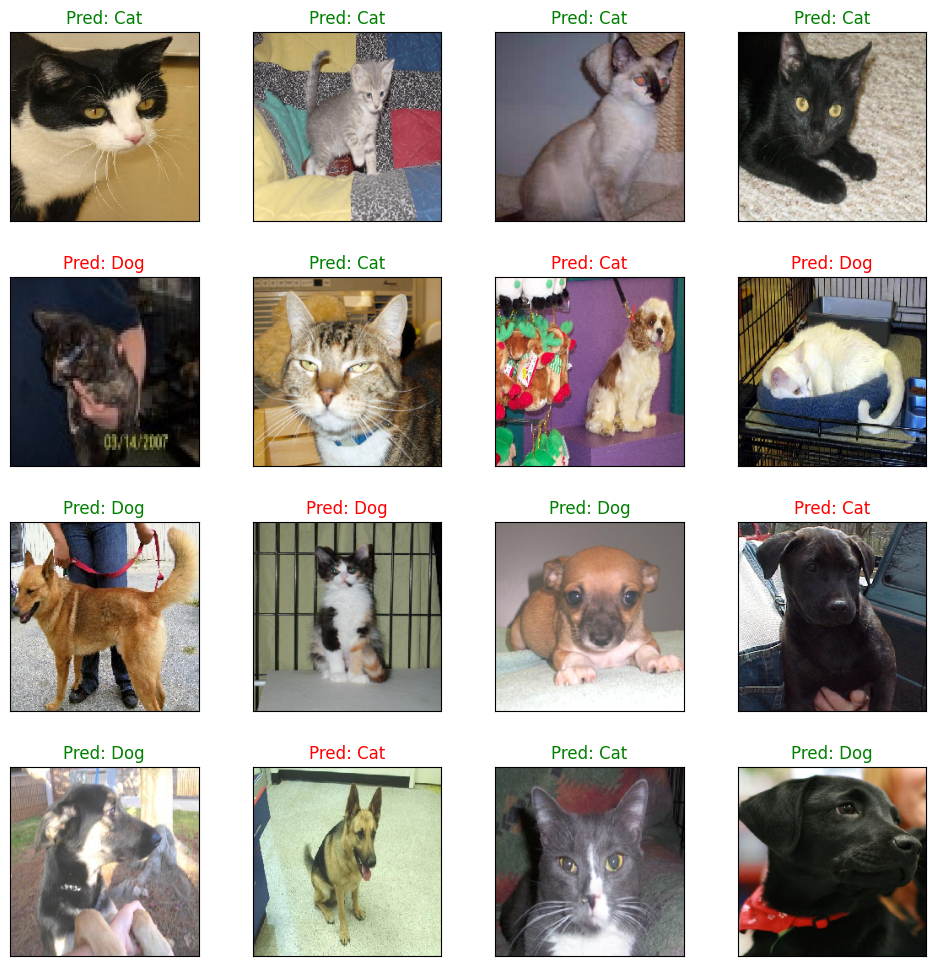


cnn_best_model평가 결과: Loss: 0.6181, Accuracy: 0.6250


In [19]:
# best 모델 로드
cnn_best_model = load_model("./model/cnn_catanddog.keras")

#클래스 이름 출력하기
class_indices = valid_gen.class_indices
class_names = [k for k, v in sorted(class_indices.items(), key=lambda x: x[1])]
validation_batch, label_batch = next(iter(valid_gen))

cnn_pred =  cnn_best_model.predict(validation_batch)
pred_values = np.argmax(cnn_pred, axis=1)
true_values = np.argmax(label_batch, axis=1)

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.3)

num_images = min(16,validation_batch.shape[0])

for i in range(num_images):
    ax = fig.add_subplot(4,4, i +1, xticks=[], yticks=[] )
    ax.imshow(validation_batch[i], cmap=plt.cm.gray_r)
    
    pred_label = class_names[pred_values[i]]
    true_label =  class_names[true_values[i]]
    color = 'green' if pred_values[i] == true_values[i] else 'red'
    ax.set_title(f"Pred: {pred_label}", color=color, fontsize= 12)
plt.show()

# loss와 accuracy 출력
loss, acc = cnn_best_model.evaluate(validation_batch, label_batch, verbose=0)
print(f"\ncnn_best_model평가 결과: Loss: {loss:.4f}, Accuracy: {acc:.4f}")

In [74]:
num_images

NameError: name 'num_images' is not defined

# keras 홈페이지 
* 여기서 api 사용가능
* 숫자가 커지면 파라미터가 크다는 뜻

* https://keras.io/api/applications/
* https://ai.google.dev/edge/mediapipe/solutions/guide?hl=ko

# 전이 학습
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 튜닝을 하거나 결과를 출력
* KERAS.APPLICATIONS에 있음

# ResNet50 
* ResNet50 에 사용할 경우, rescale=1./255는 제거하고 preprocessing_funtion = preprocess_input을 사용
* Keras의 는 입력이미지를 BRG로 바꾸고 채널별 평균을 뺴는 전처리를 필요로 하기 때문

In [92]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152V2


In [100]:
base_model = ResNet50(
    include_top=False,
    preprocessing_funtion = preprocess_input,
    weights='imagenet',
    input_tensor = None,
    input_shape=(244,244,3),
    pooling='avg')

NameError: name 'preprocess_input' is not defined

In [43]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 250, 250,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 122, 122,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 122, 122,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 122, 122,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 124, 124,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 61, 61,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 61, 61,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 61, 61,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 61, 61,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 61, 61,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 61, 61,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 61, 61,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 61, 61,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 61, 61,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 61, 61,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 61, 61,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [98]:
base_model.trainable = False
res50_model = Sequential()
res50_model.add(base_model)
res50_model.add(Dense(2, activation='softmax'))
res50_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [99]:
res50_model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
model_path = "./model/res50_catndog.keras"
check_point = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
res50_history = res50_model.fit(train_gen, epochs=1000, validation_data=valid_gen,
                           callbacks=[early_stop, check_point])
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'valid'])
plt.show()

Epoch 1/1000


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 244, 244, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

In [95]:
# best 모델 로드
res50_model = load_model("./model/res50_model_catanddog.keras")

#클래스 이름 출력하기
class_indices = valid_gen.class_indices
class_names = [k for k, v in sorted(class_indices.items(), key=lambda x: x[1])]
validation_batch, label_batch = next(iter(valid_gen))

res50_pred =  res50_model.predict(valid_batch)
pred_values = np.argmax(cnn_pred, axis=1)
true_values = np.argmax(label_batch, axis=1)

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.3)

num_images = min(16,validation_batch_shape[0])

for i in range(num_images):
    ax = fig.add_subplot(4,4, i +1, xticks=[], yticks=[] )
    ax.imshow(validation_batch[i], cmap=plt.cm.gray_r)
    
    pred_label = class_name[pred_values[i] ]
    true_label =  class_names[true_values[i]]
    color = 'green' if pred_values[i] == true_values[i] else 'red'
    ax.set_title(f"Pred: {pred_label}", color=color, fontsize= 12)
plt.show()

# loss와 accuracy 출력
loss, acc = cnn_best_model.evaluate(validation_batch, label_batch, verbose=0)
print(f"\ncnn_best_model평가 결과: Loss: {loss:.4f}, Accuracy: {acc:.4f}")

ValueError: File not found: filepath=./model/res50_model_catanddog.keras. Please ensure the file is an accessible `.keras` zip file.

# ResNet152V2

In [109]:
base_model2 = ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg'
)

In [110]:
base_model2.summary()

Model: "resnet152v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_19[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 58,331,648 (222.52 MB)

 Trainable params: 58,187,904 (221.97 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [111]:
base_model2.trainbale = False
res152v2_model = Sequential()
res152v2_model.add(base_model2)
res152v2_model.add(Dense(2, activation='softmax'))

In [112]:
res152v2_model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['accuracy'])
model_path = "./model/res152v2_catanddog.keras"
check_point = ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss", verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, )
res152v2_history = res152v2_model.fit(train_gen, epochs=1000, validation_data=valid_gen,
                           callbacks=[early_stop, check_point])
plt.plot(res152v2_history.history['loss'])
plt.plot(res152v2_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.leggend(['train','vaild'])
plt.show()

Epoch 1/1000


2025-05-21 03:08:55.750843: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 65.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-21 03:08:56.040111: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.277 = (f32[16,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0} %transpose.1551, f32[64,3,7,7]{3,2,1,0} %transpose.1552, f32[64]{0} %arg3.4), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_13_1/resnet152v2_1/conv1_conv_1/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_li

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_29/108577699.py", line 7, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.277 = (f32[16,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0} %transpose.1551, f32[64,3,7,7]{3,2,1,0} %transpose.1552, f32[64]{0} %arg3.4), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_13_1/resnet152v2_1/conv1_conv_1/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 68157440 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_298096]

In [ ]:
# best 모델 로드
res50_model = load_model("./model/res50_model_catanddog.keras")

#클래스 이름 출력하기
class_indices = valid_gen.class_indices
class_names = [k for k, v in sorted(class_indices.items(), key=lambda x: x[1])]
validation_batch, label_batch = next(iter(valid_gen))

res50_pred =  res50_model.predict(valid_batch)
pred_values = np.argmax(cnn_pred, axis=1)
true_values = np.argmax(label_batch, axis=1)

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.3)

num_images = min(16,validation_batch_shape[0])

for i in range(num_images):
    ax = fig.add_subplot(4,4, i +1, xticks=[], yticks=[] )
    ax.imshow(validation_batch[i], cmap=plt.cm.gray_r)
    
    pred_label = class_name[pred_values[i] ]
    true_label =  class_names[true_values[i]]
    color = 'green' if pred_values[i] == true_values[i] else 'red'
    ax.set_title(f"Pred: {pred_label}", color=color, fontsize= 12)
plt.show()

# loss와 accuracy 출력
loss, acc = cnn_best_model.evaluate(validation_batch, label_batch, verbose=0)
print(f"\ncnn_best_model평가 결과: Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# convnextbase로 분석하기
* convnextbase는 내부에 정규화 레이어가 있으므로  입력시 정규화 X
* 이미지 타입도 float 32로 맞춰줘야함

In [56]:
from tensorflow.keras.applications import ConvNeXtBase

In [57]:
base_model3 =  ConvNeXtBase(
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
    name="convnext_base",
)

355031056/355031056 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


In [ ]:
base_model3.trainable = False
ConvNeXtBase_model = Sequential()
ConvNeXtBase_model.add(base_model)
ConvNeXtBase_model.add(Dense(2, activation='softmax'))

In [ ]:
# best 모델 로드
res50_model = load_model("./model/res50_model_catanddog.keras")

#클래스 이름 출력하기
class_indices = valid_gen.class_indices
class_names = [k for k, v in sorted(class_indices.items(), key=lambda x: x[1])]
validation_batch, label_batch = next(iter(valid_gen))

res50_pred =  res50_model.predict(valid_batch)
pred_values = np.argmax(cnn_pred, axis=1)
true_values = np.argmax(label_batch, axis=1)

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.3)

num_images = min(16,validation_batch_shape[0])

for i in range(num_images):
    ax = fig.add_subplot(4,4, i +1, xticks=[], yticks=[] )
    ax.imshow(validation_batch[i], cmap=plt.cm.gray_r)
    
    pred_label = class_name[pred_values[i] ]
    true_label =  class_names[true_values[i]]
    color = 'green' if pred_values[i] == true_values[i] else 'red'
    ax.set_title(f"Pred: {pred_label}", color=color, fontsize= 12)
plt.show()

# loss와 accuracy 출력
loss, acc = cnn_best_model.evaluate(validation_batch, label_batch, verbose=0)
print(f"\ncnn_best_model평가 결과: Loss: {loss:.4f}, Accuracy: {acc:.4f}")

In [113]:
!pip install deepface
!pip install tf-keras

  Preparing metadata (setup.py) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 9.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.8 MB/s eta 0:00:00a 0:00:01
  DEPRECATION: Building 'fire' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fire'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=889096082bc132326602e732db00b8ede8114deb1566d0b196411b3d204a7c1b
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b86

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 7.5 MB/s eta 0:00:0000:0100:03
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 7.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard━━━━━━━━━━━━━ 0/4 [ml-dtypes]
    Found existing installation: tensorboard 2.17.032m0/4 [ml-dtypes]
    Uninstalling tensorboard-2.17.0:━━━━━━━━ 0/4 [ml-dtypes]
      Successfully uninstalled tensorboard-2.17.0━━━━━━━━━━━━━━━━━ 1/4 [tensorboard]
  Attempting uninstall: tensorflow90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [tensorboard]
    Found existing installation: tensorflow 2.17.0━━━━━━━━━━━━ 1/4 [tensorboard]
    Uninstalling tensorflow-2.1

In [114]:
import gradio as gd
import pandas as pd

ModuleNotFoundError: No module named 'gradio'

# dbtkeh %

In [115]:
def convert_distance_to_similarity(distance, threshhold, verified):
    if verified:
        # 일치할 경우
        ratio = max(0, 1-(distance/threshhold))
        return round(90 + ratio * 10,2)
    else :
        # 불일치할 경우
        raio = max(0, 1-(distance/(threshhold * 2)))
        return round(ratio * 60, 2)

# 얼굴유사도 비교 함수 (ArcFace)

In [116]:
def image_to_text(image1,image2):
    if image1 is None or image2 is None:
        return "두 이미지 모두 업로드 해주세요"
    image1 = 